In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
from scipy.io import savemat, loadmat
import optax
from matplotlib import cm
from copy import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None

dataset = "2020-10-06-7"
estim = "data003/data003-all"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac
l2_reg = 0
R2_thresh = 0.02

p = 3
cell = 296

X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                        load_from_mat=True, 
                                        MATFILE_BASE=MATFILE_BASE)
X_all = jnp.array(sm.add_constant(mutils.get_stim_amps_newlv(electrical_path, p), has_constant='add'))
X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)

In [4]:
ms = [2, 3, 4, 5, 6]

w_inits = []
for m in ms:
    w_init = np.array(np.random.normal(size=(m, X_expt.shape[1]+1)))
    w_inits.append(w_init)

output = fitting.fit_triplet_surface_new(X_expt, probs, T, w_inits, method=method, jac=jac, reg_method='l2', 
                                        reg=l2_reg, R2_thresh=R2_thresh, verbose=True)
w_true = jnp.array(output[0])
w_inits = output[1]

31774.597544666736
(array([[-5.67358361, -2.57493625, -3.50218167, -2.82012266],
       [-5.69128195,  2.44748286,  3.24051753,  2.76124697]]), 19348.593207476977, 0.3910672454536068) 0.3910672454536068
(array([[-5.96413308,  2.56579885,  3.36324852,  2.91778064],
       [-5.69708599, -0.80142084,  0.12381381, -1.43112277],
       [-6.28324215, -2.76848224, -3.91887464, -3.00439891]]), 19237.02375393494, 0.3945785237124486) 0.3945785237124486


In [5]:
print(w_true)
X_expt_orig = mutils.get_stim_amps_newlv(electrical_path, p)
p_true = activation_probs(jnp.array(sm.add_constant(X_expt_orig, has_constant='add')), w_true) # prob with each current level
X = jnp.array(X_expt_orig)

[[-5.6735835 -2.5749362 -3.5021818 -2.8201227]
 [-5.691282   2.4474828  3.2405176  2.761247 ]]


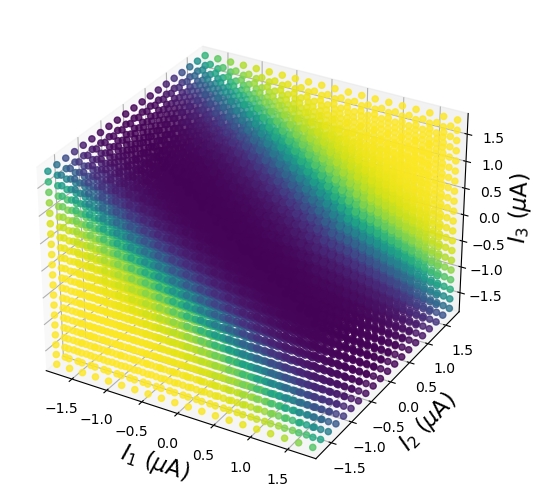

In [6]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true, s=20, alpha=0.8, vmin=0, vmax=1)

In [7]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [8]:
def fisher_info(x, w, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    # sign, logdet = jnp.linalg.slogdet(I_w)
    # loss = -sign * logdet
    return loss

In [9]:
def optimize_fisher(x, w, t_prev, t, reg=0, step_size=0.001, n_steps=100, reltol=-np.inf, T_budget=5000, step_cnt_decrement=5):

    optimizer = optax.adamw(step_size)
    opt_state = optimizer.init(t)

    @jax.jit
    def update(x, w, t_prev, t):
        fisher_lambda = lambda t, x, w, t_prev: fisher_info(x, w, t_prev + jnp.absolute(t))  + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)
        # fisher_lambda = lambda t, x, w, t_prev: fisher_info(x, w, t_prev + jnp.absolute(t))  + reg * jnp.sum(jnp.absolute(t))

        grads = jax.grad(fisher_lambda)(t, x, w, t_prev)

        return grads
    
    losses = []
    for step in range(n_steps):
        grads = update(x, w, t_prev, t)
        updates, opt_state = optimizer.update(grads, opt_state, params=t)
        t = optax.apply_updates(t, updates)
        # grad = update(x, w, t_prev, t)
        # t = t - step_size * grad
    
        losses += [[fisher_info(x, w, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    # fisher_info(x, w, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))]]
                    fisher_info(x, w, t_prev + jnp.absolute(t)) + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)]]
        
        # if step % step_cnt_decrement == 0:
        #     step_size = step_size * 0.95

    return np.array(losses), t

In [10]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

Restart 1


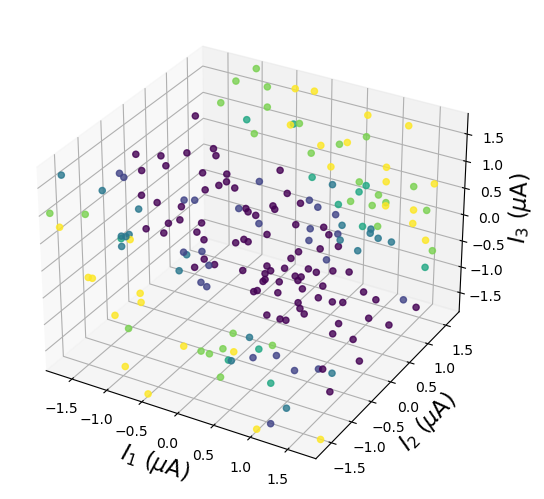

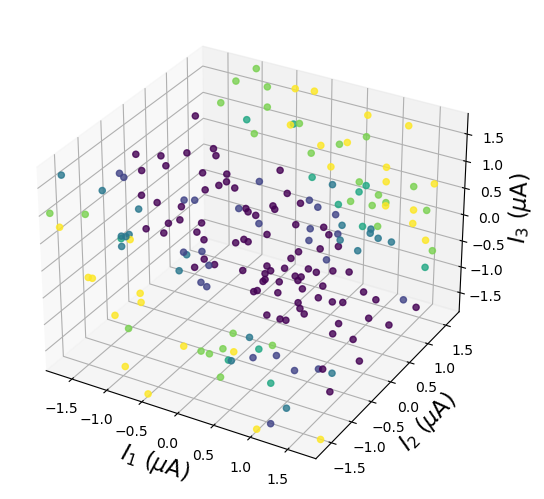

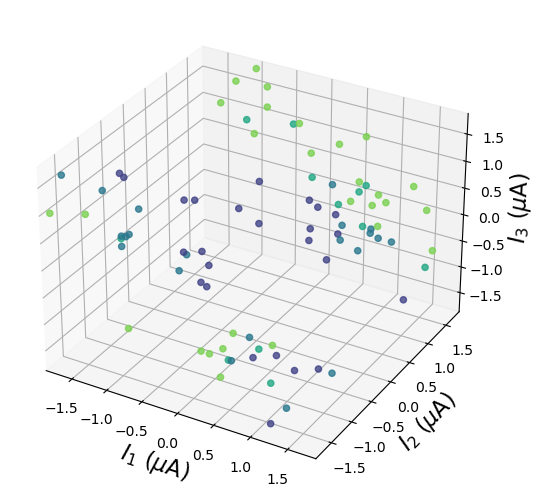

298.0532876407765
(array([[-5.29078277, -2.39488089, -3.1005354 , -2.4677345 ],
       [-5.29078277,  2.03898867,  2.90070456,  2.78229487]]), 287.7589153480787, 0.03453869733892989) 0.03453869733892989
(array([[-5.69708599, -2.04544778, -3.45678509, -1.79746652],
       [-5.69708599,  2.08569655,  2.93571093,  3.16084417],
       [-5.69708599,  0.01340748,  1.2508414 , -3.30076467]]), 278.58069019747177, 0.0653326041039135) 0.0653326041039135
(array([[-5.98518703, -1.42864084, -1.13169554, -3.47389008],
       [-5.98518703,  2.81162908,  2.10935154,  2.32017129],
       [-5.98518703, -1.12920439, -3.6329344 , -0.70576138],
       [-5.98518703, -0.23466773,  3.93095967,  0.91717067]]), 273.90495363910776, 0.08102019002311123) 0.08102019002311123
[[-5.697086   -2.0454478  -3.4567852  -1.7974665 ]
 [-5.697086    2.0856965   2.935711    3.160844  ]
 [-5.697086    0.01340748  1.2508414  -3.3007646 ]]
[[-5.697086   -2.0454478  -3.4567852  -1.7974665 ]
 [-5.697086    2.0856965   2.935711    

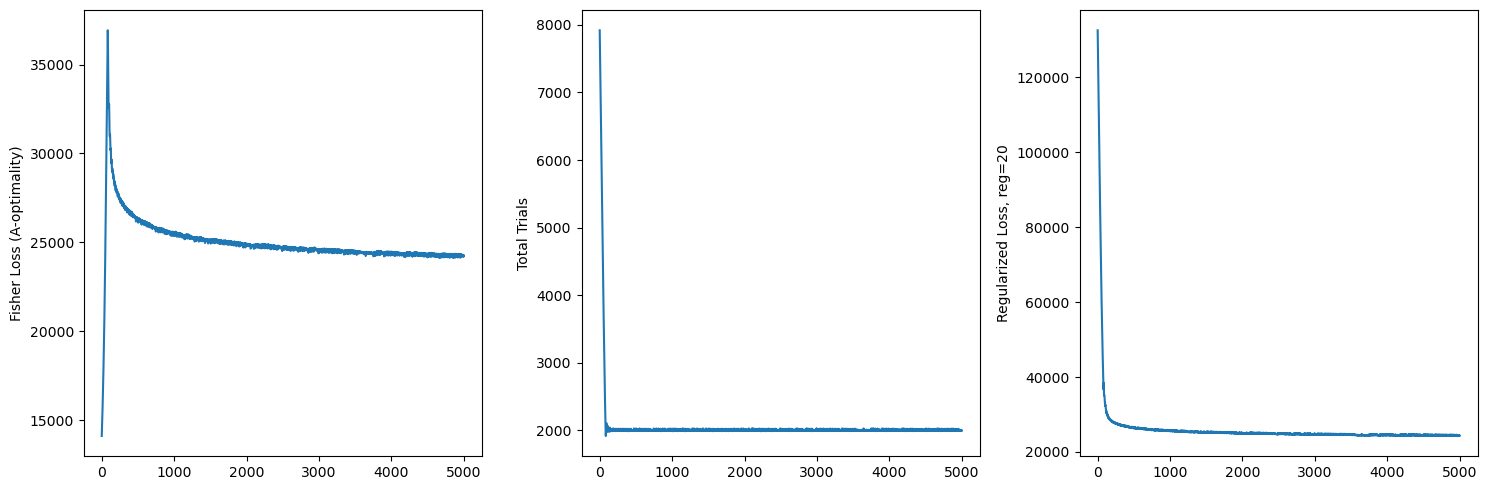

1930.0


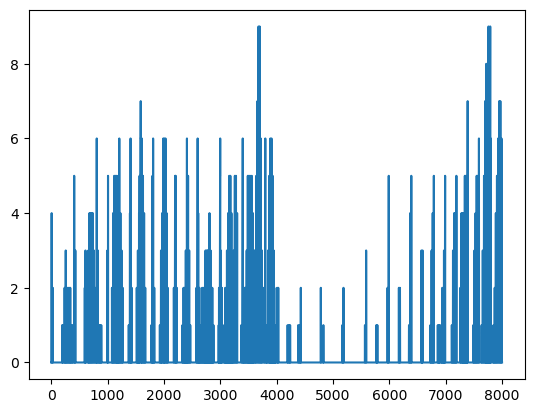

2000.0


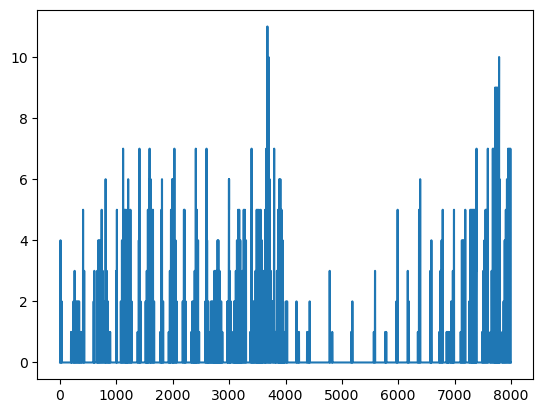

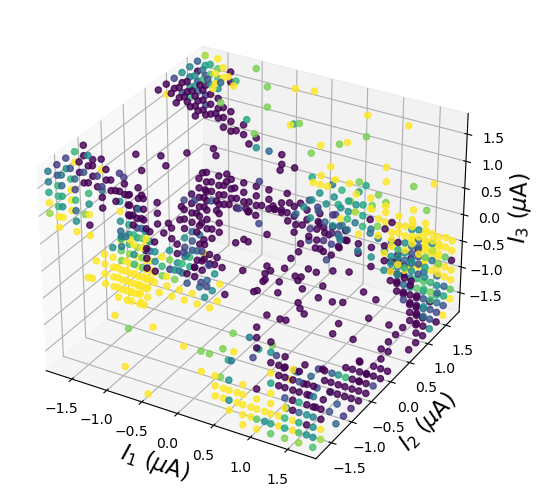

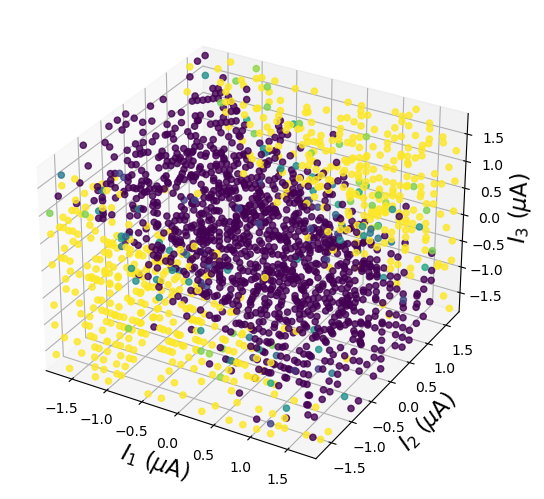

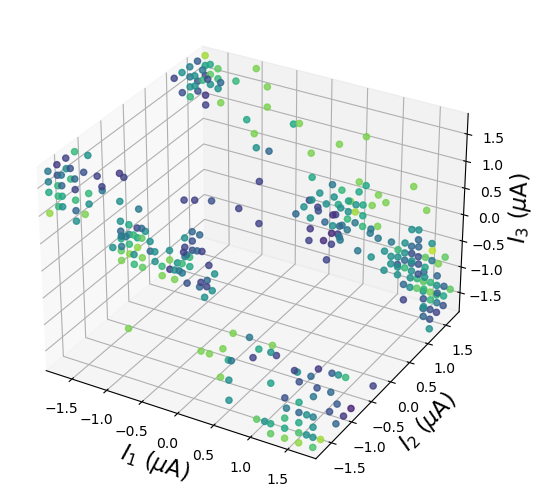

961.6115588850976
(array([[-5.29078277, -2.26825435, -3.14339763, -2.58242257],
       [-5.29078277,  2.13957334,  3.05028685,  2.52153587]]), 947.3184023212068, 0.014863752865515) 0.014863752865515
(array([[-5.69708599, -2.33164035, -3.37037378, -2.47927017],
       [-5.69708599,  2.1080593 ,  2.9943161 ,  2.88346818],
       [-5.69708599,  0.24583118,  0.85204032, -2.48786574]]), 927.4646585684798, 0.03551007680919316) 0.03551007680919316
(array([[-5.98518703, -2.5638115 , -2.9621603 , -2.50285661],
       [-5.98518703,  2.19298789,  3.19738209,  2.95822755],
       [-5.98518703,  0.1088705 , -2.91930246, -0.16014953],
       [-5.98518703,  0.3963643 ,  0.75661502, -2.5962451 ]]), 921.6030498452811, 0.04160568648551055) 0.04160568648551055
[[-5.697086   -2.3316402  -3.3703737  -2.4792702 ]
 [-5.697086    2.1080594   2.994316    2.8834682 ]
 [-5.697086    0.24583118  0.85204035 -2.4878657 ]]


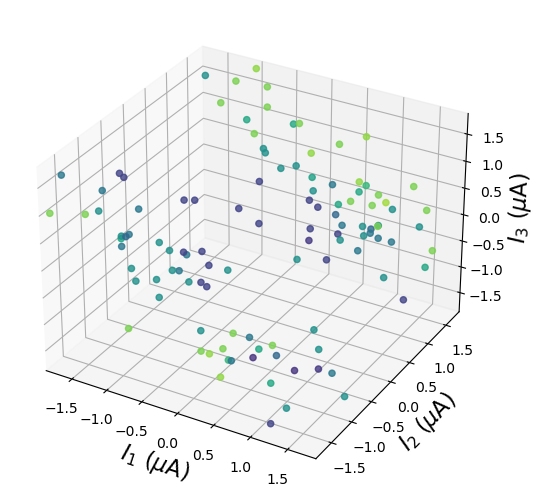

352.08333382971955
(array([[-5.29078277, -2.33637725, -3.10880276, -2.55666478],
       [-5.29078277,  2.04184616,  2.9386828 ,  2.78704011]]), 350.5650773357073, 0.0043122077875645815) 0.0043122077875645815
(array([[-5.69708599, -2.12237461, -3.42735306, -1.8910037 ],
       [-5.69708599,  2.08059695,  2.96569538,  3.18982215],
       [-5.69708599,  0.04193019,  1.15310232, -3.33815096]]), 336.51898401663965, 0.04420643727660056) 0.04420643727660056
(array([[-5.98518703, -0.54778362, -0.04689038, -3.58840139],
       [-5.98518703,  2.5392858 ,  2.00503349,  2.77066499],
       [-5.98518703, -2.0751088 , -3.55687776, -1.684797  ],
       [-5.98518703,  0.07722319,  3.98431244,  0.83503874]]), 333.8655373370576, 0.05174285387070532) 0.05174285387070532
[[-5.697086   -2.1223745  -3.4273531  -1.8910037 ]
 [-5.697086    2.080597    2.9656954   3.1898222 ]
 [-5.697086    0.04193019  1.1531023  -3.338151  ]]
0.09406937 0.19288684


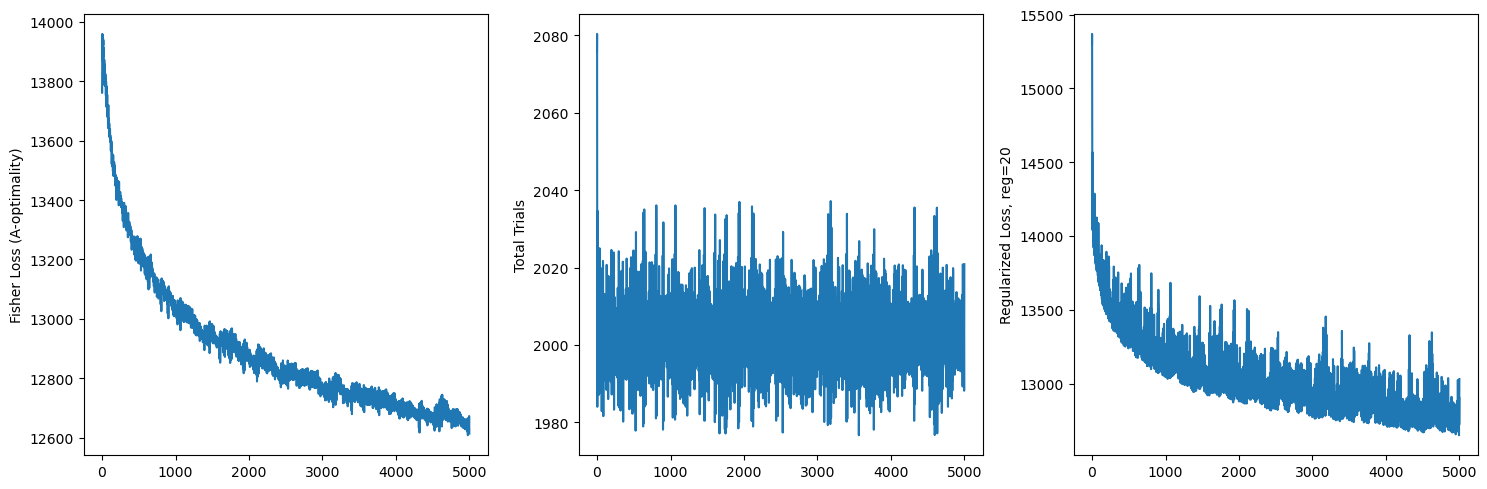

1858.0


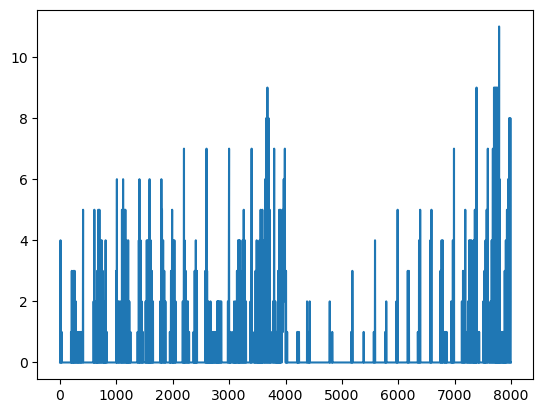

2000.0


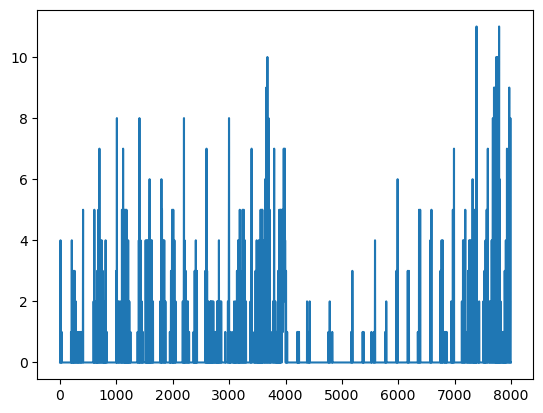

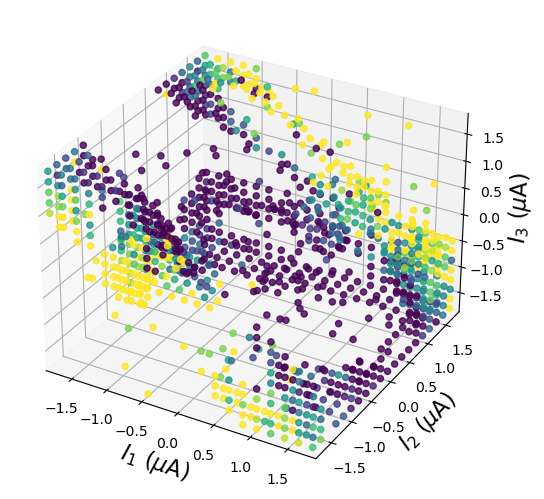

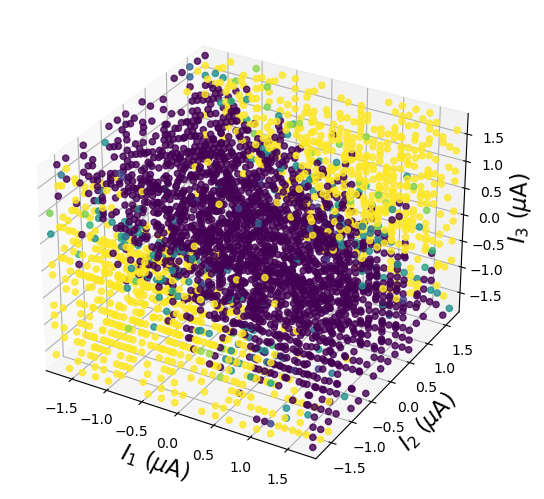

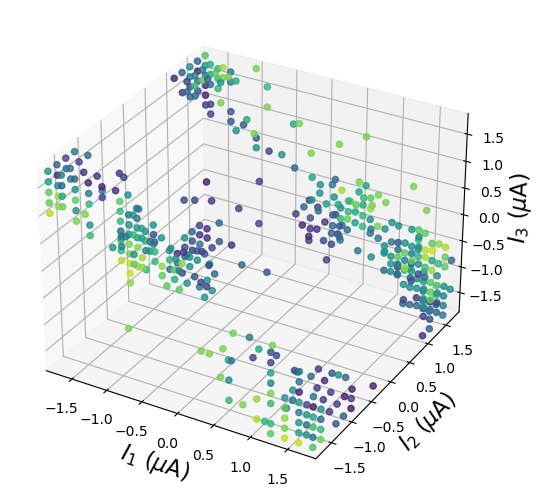

2017.1710398533423
(array([[-5.29078277, -2.35264167, -3.21999622, -2.62808753],
       [-5.29078277,  2.21633384,  3.0355521 ,  2.50462366]]), 1835.34697213444, 0.0901381509681608) 0.0901381509681608
(array([[-5.69708599, -2.45379911, -3.48614154, -2.6765363 ],
       [-5.69708599,  2.26456664,  3.09252458,  2.79456681],
       [-5.69708599,  0.25079438,  0.9737516 , -1.78534213]]), 1820.6488720302084, 0.09742464270031459) 0.09742464270031459
[[-5.290783  -2.3526416 -3.2199962 -2.6280875]
 [-5.290783   2.2163339  3.035552   2.5046237]]


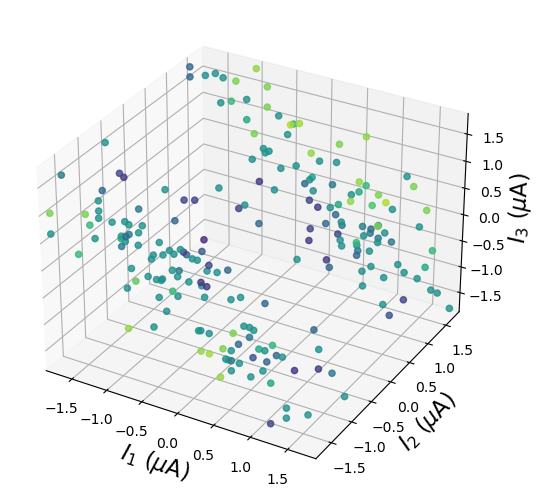

532.3266179562756
(array([[-5.29078277, -2.36030918, -3.11319437, -2.52876824],
       [-5.29078277,  2.2021762 ,  3.05951682,  2.52972591]]), 565.1806136382518, -0.061717739774332925) -0.061717739774332925
(array([[-5.69708599, -2.13191474, -3.48658942, -1.90120086],
       [-5.69708599,  2.23962108,  2.9821743 ,  3.00797876],
       [-5.69708599, -0.09351755,  0.97936369, -3.22727488]]), 546.2786481978471, -0.026209529583804292) -0.026209529583804292
(array([[-5.98518703, -0.35148225,  0.08665706, -3.47716661],
       [-5.98518703,  2.52628199,  2.41893717,  3.02284986],
       [-5.98518703, -2.18889596, -3.62231961, -1.82687597],
       [-5.98518703, -0.15041483,  3.72207557,  0.18877994]]), 540.7003726299232, -0.015730482735949458) -0.015730482735949458
[[-5.697086   -2.1319149  -3.4865894  -1.9012009 ]
 [-5.697086    2.2396212   2.9821744   3.0079787 ]
 [-5.697086   -0.09351756  0.9793637  -3.227275  ]]
0.014651018 0.16814479


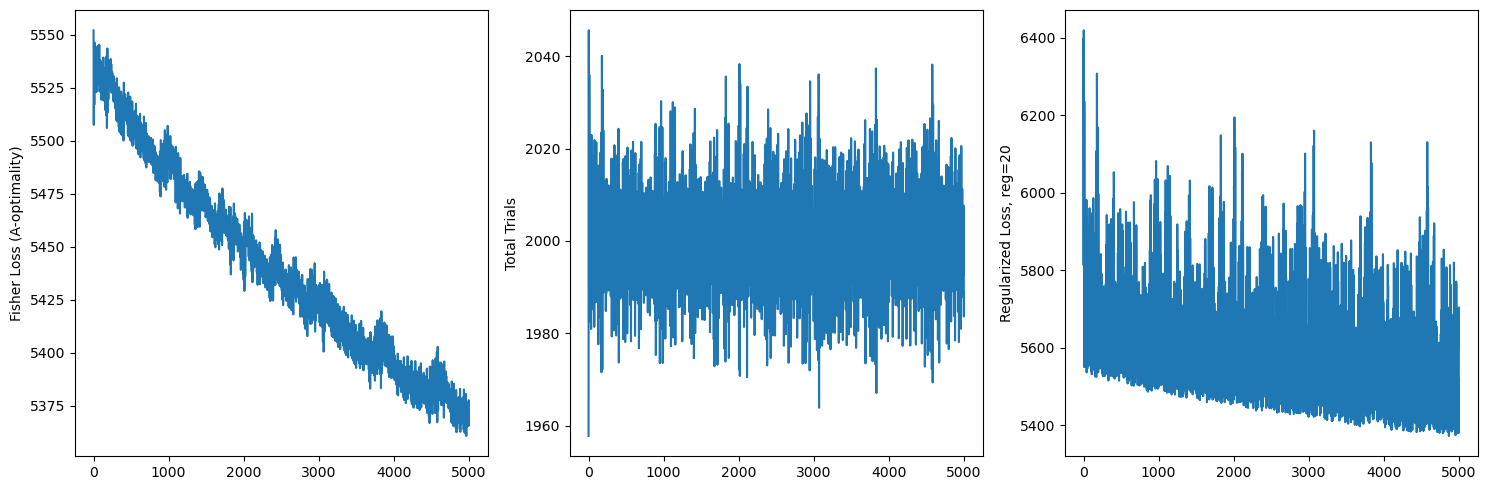

1810.0


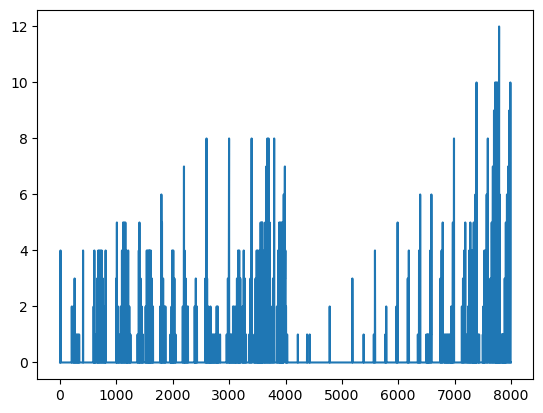

2000.0


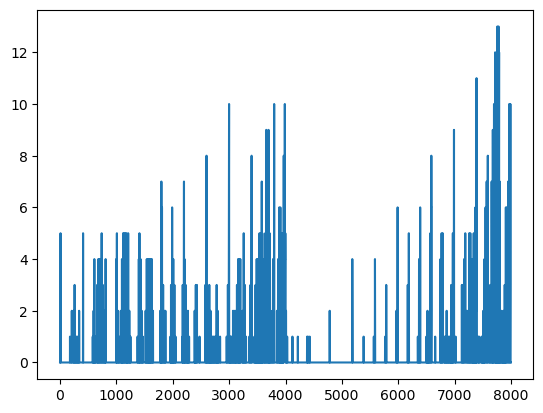

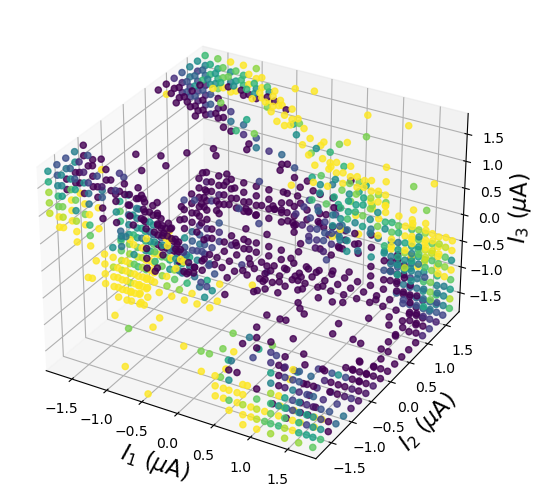

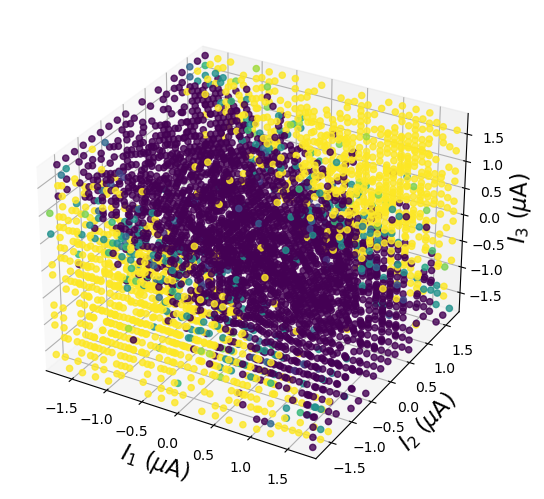

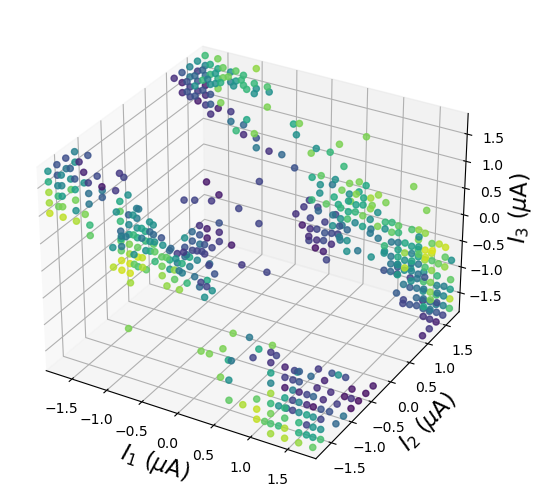

3264.4837268421597
(array([[-5.29078277, -2.41393526, -3.23245026, -2.63079373],
       [-5.29078277,  2.26273607,  3.03802915,  2.47505453]]), 2769.7262472844623, 0.15155764922017) 0.15155764922017
(array([[-5.69708599, -2.54457341, -3.49591241, -2.75832409],
       [-5.69708599,  2.34430301,  3.13405821,  2.7236065 ],
       [-5.69708599,  0.2655157 ,  1.44386785, -0.96400381]]), 2765.329025669269, 0.15290463759050166) 0.15290463759050166
[[-5.290783  -2.4139352 -3.2324502 -2.6307938]
 [-5.290783   2.262736   3.0380292  2.4750545]]


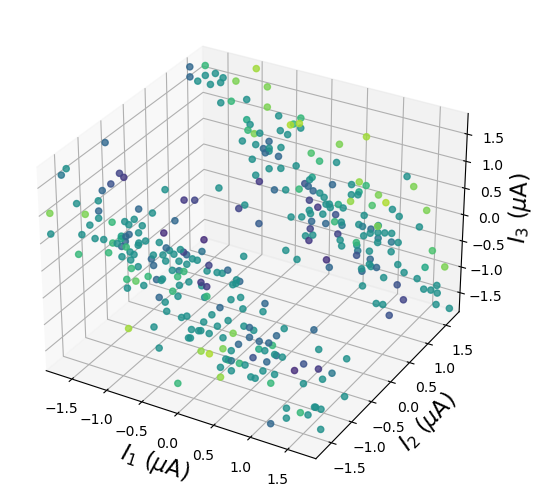

763.5868293009763
(array([[-5.29078277, -2.16724061, -3.14803567, -2.5310765 ],
       [-5.29078277,  2.27326426,  3.03903954,  2.61069514]]), 834.3025152794548, -0.09260988176448115) -0.09260988176448115
(array([[-5.69708599, -1.74123346, -3.59644674, -1.66514505],
       [-5.69708599,  2.32963243,  3.0110004 ,  3.03680476],
       [-5.69708599, -0.30966055,  0.72885125, -3.3475402 ]]), 802.6272856556033, -0.05112772360199869) -0.05112772360199869
(array([[-5.98518703, -0.74956538, -0.3482684 , -3.54977317],
       [-5.98518703,  2.49370044,  2.41338132,  3.20843024],
       [-5.98518703, -1.72575084, -3.72637262, -1.48939913],
       [-5.98518703,  0.11248702,  3.63022679,  0.10773828]]), 796.4259852195282, -0.043006446232990214) -0.043006446232990214
[[-5.697086   -1.7412335  -3.5964468  -1.665145  ]
 [-5.697086    2.3296325   3.0110004   3.0368047 ]
 [-5.697086   -0.30966055  0.72885126 -3.3475401 ]]
0.014009768 0.16972706


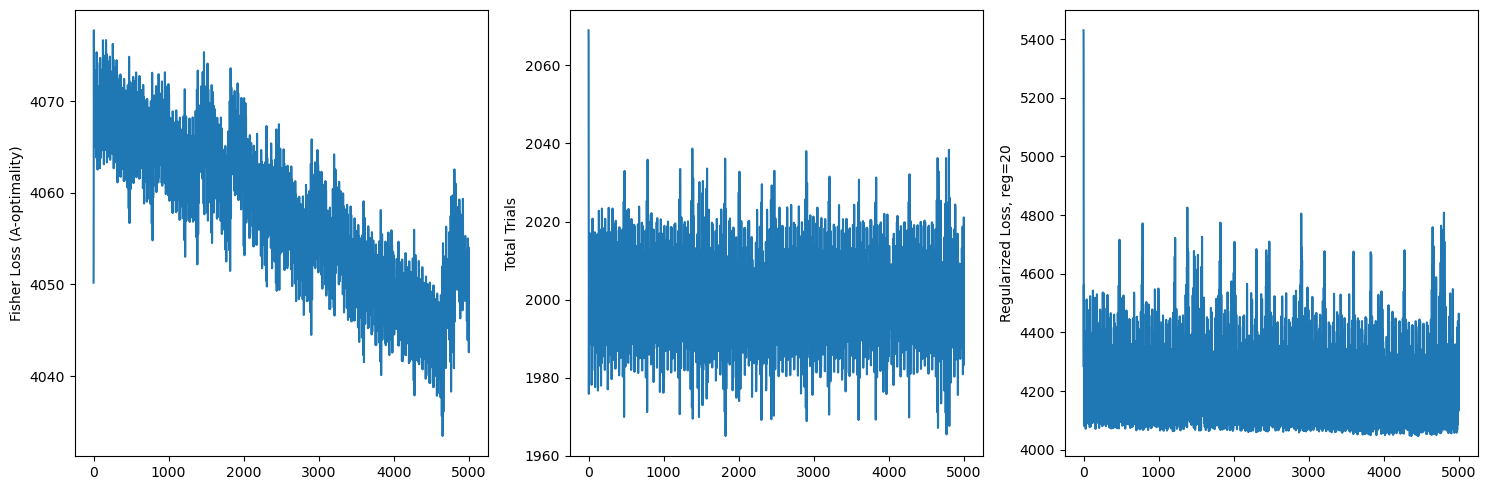

1810.0


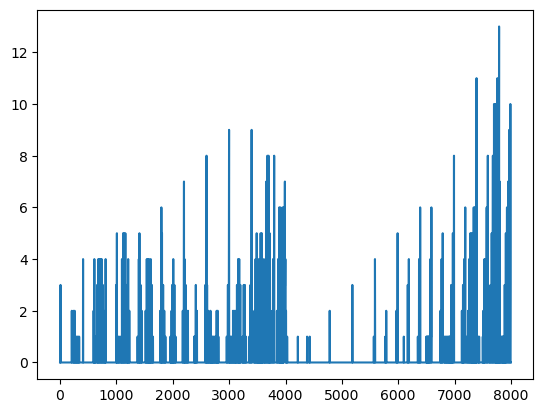

2000.0


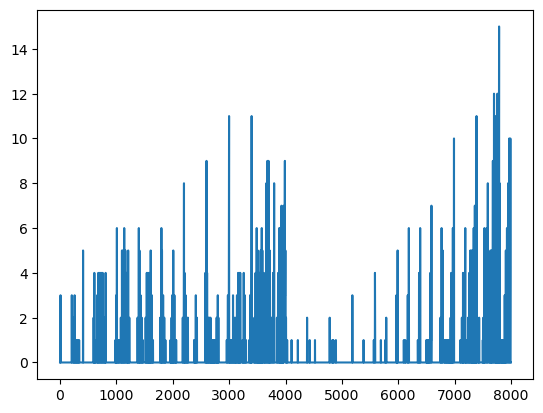

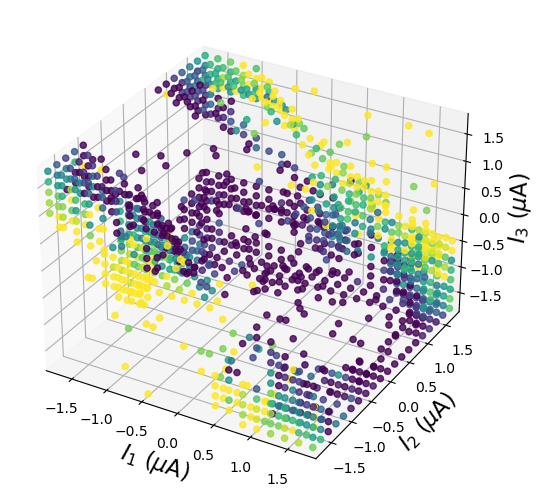

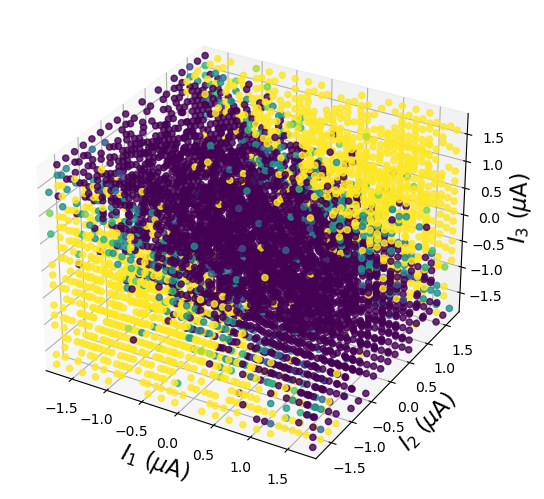

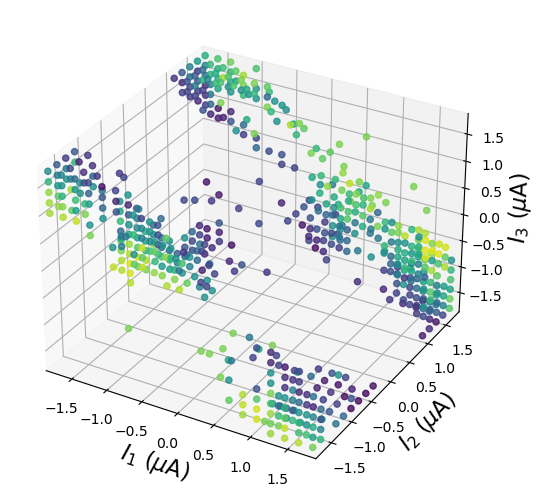

4649.329582418175
(array([[-5.29078277, -2.42511613, -3.26556764, -2.6485019 ],
       [-5.29078277,  2.27997687,  3.03596505,  2.50531451]]), 3824.3735317333344, 0.17743548528038977) 0.17743548528038977
(array([[-5.69708599, -2.5734345 , -3.5238997 , -2.80546217],
       [-5.69708599,  2.37837949,  3.13928013,  2.73418414],
       [-5.69708599,  0.30217886,  1.69402148, -0.4535646 ]]), 3822.162808388681, 0.177910978210169) 0.177910978210169
[[-5.290783  -2.425116  -3.2655675 -2.6485019]
 [-5.290783   2.2799768  3.035965   2.5053146]]


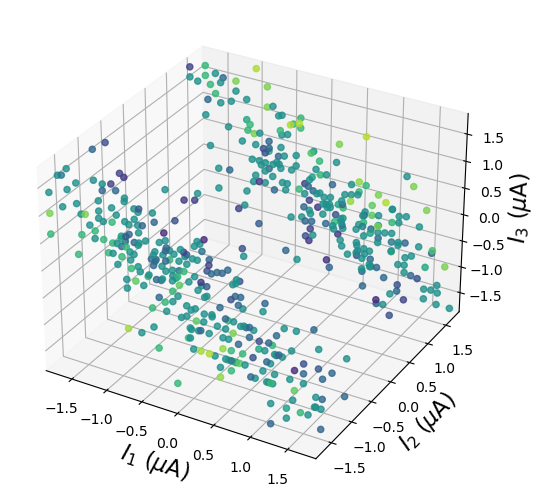

1074.1655559234696
(array([[-5.29078277, -2.19049161, -3.19743504, -2.52543246],
       [-5.29078277,  2.22437496,  3.02916475,  2.7050667 ]]), 1176.8477529137501, -0.09559252428458653) -0.09559252428458653
(array([[-5.69708599, -1.93175944, -3.57412032, -1.83253765],
       [-5.69708599,  2.26708893,  3.03899366,  3.10718071],
       [-5.69708599, -0.11264888,  0.5676556 , -3.23459365]]), 1145.5774498959413, -0.06648127337417575) -0.06648127337417575
(array([[-5.98518703, -0.68369545, -0.62560344, -3.46127584],
       [-5.98518703,  2.48606283,  2.39131573,  3.21048171],
       [-5.98518703, -1.91882411, -3.68420968, -1.60917591],
       [-5.98518703,  0.064293  ,  3.64362879,  0.17839105]]), 1133.121631944686, -0.054885464997554534) -0.054885464997554534
[[-5.697086   -1.9317595  -3.5741203  -1.8325377 ]
 [-5.697086    2.267089    3.0389936   3.1071806 ]
 [-5.697086   -0.11264888  0.5676556  -3.2345936 ]]
0.012157141 0.14779705


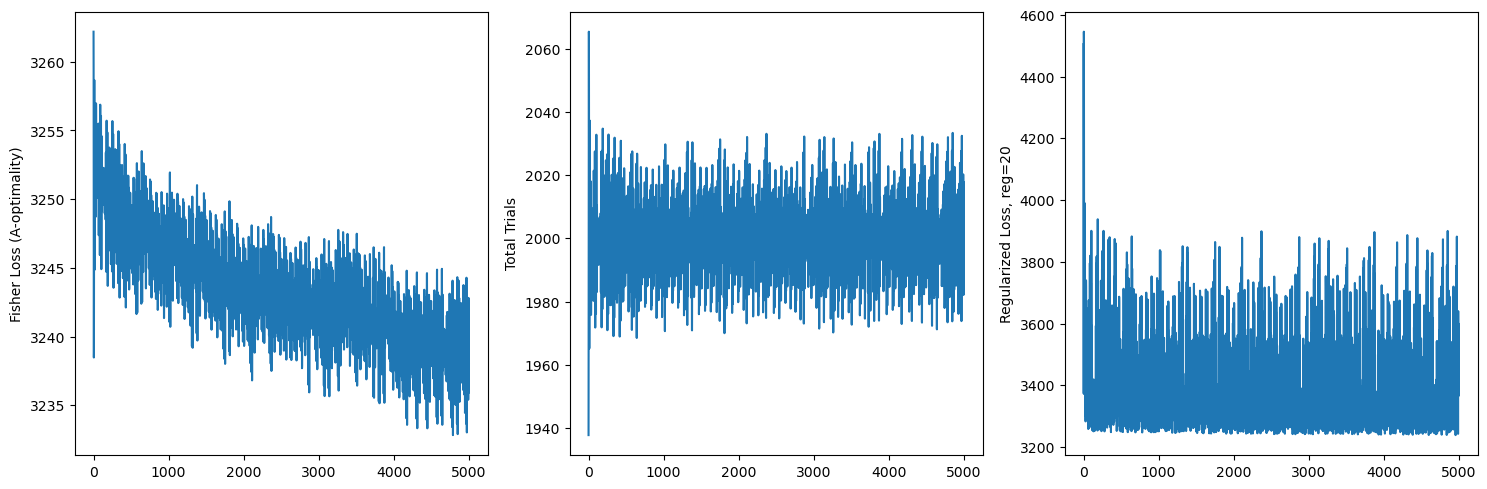

1823.0


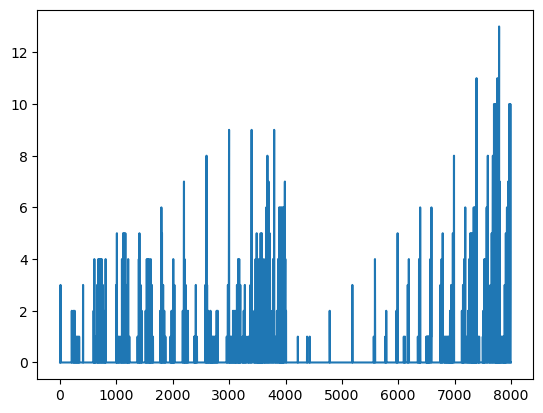

2000.0


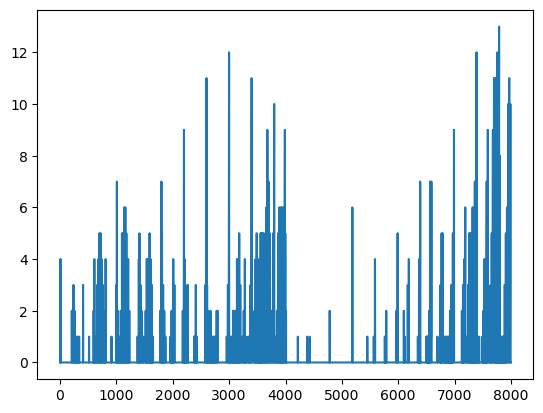

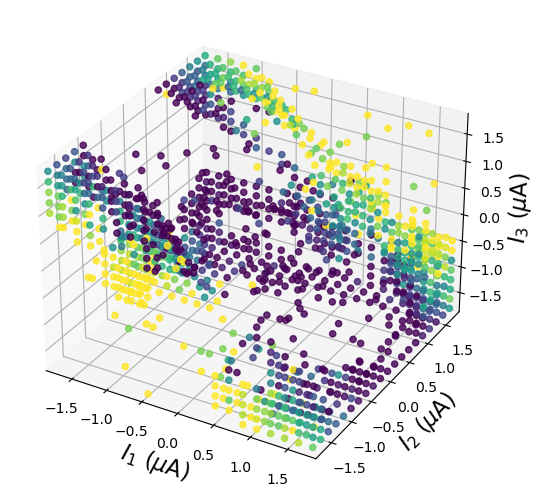

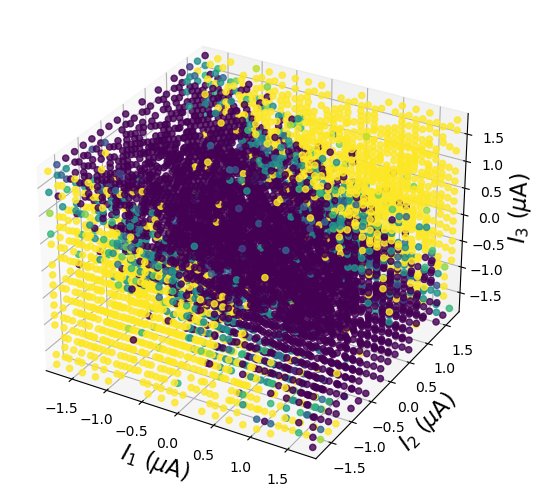

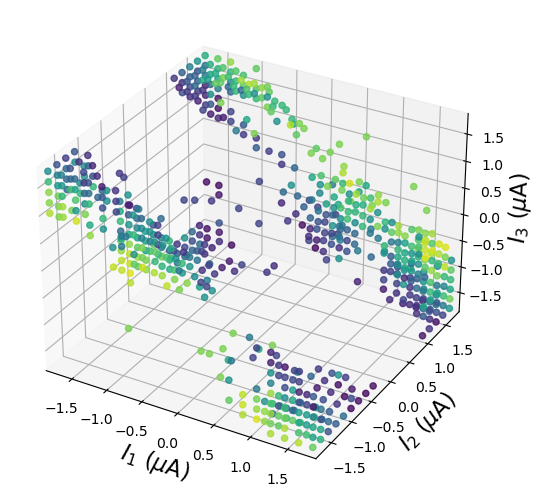

5963.561329479906
(array([[-5.29078277, -2.4193353 , -3.27960881, -2.64060649],
       [-5.29078277,  2.25983043,  3.00488637,  2.51378542]]), 4823.541228440882, 0.19116431240566234) 0.19116431240566234
(array([[-5.69708599, -2.57278906, -3.53420805, -2.80167261],
       [-5.69708599,  2.3839944 ,  3.15731263,  2.73120532],
       [-5.69708599,  0.21734929,  1.2652353 , -0.63303254]]), 4823.074510866217, 0.19124257395926758) 0.19124257395926758
[[-5.290783  -2.4193354 -3.2796087 -2.6406064]
 [-5.290783   2.2598305  3.0048864  2.5137854]]


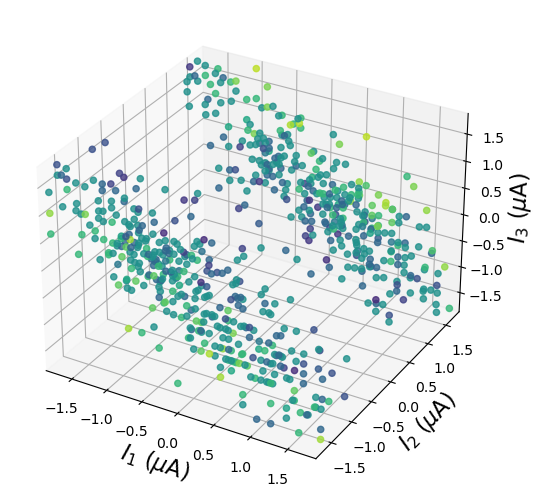

1495.6985022007646
(array([[-5.29078277, -2.16775407, -3.22806573, -2.54817347],
       [-5.29078277,  2.24154056,  3.0441526 ,  2.65790471]]), 1653.137884439667, -0.1052614427354488) -0.1052614427354488
(array([[-5.69708599, -1.93327326, -3.63298725, -2.0177589 ],
       [-5.69708599,  2.26060477,  3.03195406,  3.06300812],
       [-5.69708599, -0.14377581,  0.7966907 , -3.09407237]]), 1616.4459968113106, -0.08072983588128135) -0.08072983588128135
(array([[-5.98518703, -0.34750338, -0.04824392, -3.38100542],
       [-5.98518703,  2.51602584,  2.4421812 ,  3.13240062],
       [-5.98518703, -2.04478273, -3.74708632, -1.97582177],
       [-5.98518703,  0.04152608,  3.52956684,  0.29889827]]), 1605.3148369877372, -0.07328772117220383) -0.07328772117220383
[[-5.697086  -1.9332732 -3.6329873 -2.0177588]
 [-5.697086   2.2606049  3.031954   3.063008 ]
 [-5.697086  -0.1437758  0.7966907 -3.0940723]]
0.011701043 0.14511319


In [12]:
%matplotlib inline

total_budget = 10000
num_iters = 5
budget = int(total_budget / num_iters)
reg = 20    #np.flip(np.logspace(-5, 3, 100000, base=2))
num_restarts = 1
T_step_size = 0.01 #0.01
T_n_steps = 5000

init_size = 200
init_trials = 5

performance_stack = []
performance_stack_random = []
num_samples_stack = []

for restart in range(num_restarts):
    print('Restart', restart + 1)
    # Initialize amplitudes
    init_inds = np.random.choice(len(X), replace=False, size=init_size)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical = jnp.array(sample_spikes(p_true, T_prev))
    p_empirical_random = jnp.copy(p_empirical)

    performances = []
    performances_random = []
    num_samples = []

    w_inits = []
    for m in ms:
        w_init = np.array(np.random.normal(size=(m, X.shape[1]+1)))
        w_inits.append(w_init)

    w_inits_random = copy(w_inits)

    cnt = 0

    while True:
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
        # scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
        #             X_expt_orig[sampled_inds, 1],
        #             X_expt_orig[sampled_inds, 2], marker='o', c=T_prev[sampled_inds], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                    X_expt_orig[sampled_inds_random , 1],
                    X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        # scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
        #     X_expt_orig[sampled_inds_random , 1],
        #     X_expt_orig[sampled_inds_random , 2], marker='o', c=T_prev_random[sampled_inds_random], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        good_inds = jnp.where((p_empirical[sampled_inds] > 0) & (p_empirical[sampled_inds] < 1))[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds[good_inds], 0], 
                    X_expt_orig[sampled_inds[good_inds], 1],
                    X_expt_orig[sampled_inds[good_inds], 2], marker='o', c=p_empirical[sampled_inds][good_inds], 
                    s=20, alpha=0.8, vmin=0, vmax=1)
        # scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
        #             X_expt_orig[sampled_inds, 1],
        #             X_expt_orig[sampled_inds, 2], marker='o', c=T_prev[sampled_inds], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        output = fitting.fit_triplet_surface_new(np.array(X[sampled_inds][good_inds]), 
                                              np.array(p_empirical[sampled_inds][good_inds]),
                                              np.array(T_prev[sampled_inds][good_inds], dtype=int), w_inits,
                                              method=method, jac=jac, reg_method='l2', 
                                              reg=l2_reg, R2_thresh=R2_thresh, verbose=True)
        w_final = jnp.array(output[0])
        w_inits = output[1]

        print(w_final)

        if cnt == 0:
            T_new_init = jnp.zeros(len(T_prev)) + 1
            w_final_random = jnp.copy(w_final)
            w_inits_random = copy(w_inits)
        else:
            T_new_init = t_final
            good_inds_random = jnp.where((p_empirical_random[sampled_inds_random] > 0) & (p_empirical_random[sampled_inds_random] < 1))[0]
            
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(X_expt_orig[sampled_inds_random[good_inds_random] , 0], 
                        X_expt_orig[sampled_inds_random[good_inds_random] , 1],
                        X_expt_orig[sampled_inds_random[good_inds_random] , 2], marker='o', 
                        c=p_empirical_random[sampled_inds_random][good_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

            # scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
            #     X_expt_orig[sampled_inds_random , 1],
            #     X_expt_orig[sampled_inds_random , 2], marker='o', c=T_prev_random[sampled_inds_random], s=20, cmap=cm.jet, vmin=0, vmax=20)

            plt.show()
            
            output = fitting.fit_triplet_surface_new(np.array(X[sampled_inds_random][good_inds_random]), 
                                              np.array(p_empirical_random[sampled_inds_random][good_inds_random]),
                                              np.array(T_prev_random[sampled_inds_random][good_inds_random], dtype=int),
                                              w_inits_random, method=method, jac=jac, reg_method='l2', 
                                              reg=l2_reg, R2_thresh=R2_thresh, verbose=True)
            w_final_random = jnp.array(output[0])
            w_inits_random = output[1]

        print(w_final_random)

        performance = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final, p_true)
        performances.append(performance)
        
        performance_random = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random, p_true)
        performances_random.append(performance_random)

        print(performance, performance_random)
        # print('\n')

        if cnt >= num_iters:
            break
        
        losses, t_final = optimize_fisher(jnp.array(sm.add_constant(X, has_constant='add')), w_final, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        if jnp.sum(T_new) < budget:
            random_extra = np.random.choice(len(X), size=int(budget - jnp.sum(T_new)), 
                                            p=np.array(jnp.absolute(t_final))/np.sum(np.array(jnp.absolute(t_final))))
            T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(X))).astype(int)
            T_new = T_new + T_new_extra
            
            print(jnp.sum(T_new))
            plt.figure()
            plt.plot(T_new)
            plt.show()

        p_new = jnp.array(sample_spikes(p_true, T_new))

        p_tmp = (p_new * T_new + p_empirical * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp = p_tmp.at[jnp.isnan(p_tmp)].set(0.5)

        p_empirical = p_tmp
        T_prev = T_tmp

        # print(jnp.sum(T_tmp))

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random = jnp.array(sample_spikes(p_true, T_new_random))
        
        p_tmp_random = (p_new_random * T_new_random + p_empirical_random * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random = p_tmp_random.at[jnp.isnan(p_tmp_random)].set(0.5)

        p_empirical_random = p_tmp_random
        T_prev_random = T_tmp_random

        cnt += 1

        # input()
    
    performance_stack.append(performances)
    performance_stack_random.append(performances_random)
    num_samples_stack.append(num_samples)

In [ ]:
savemat('sampling_map_p3_n296.mat', {'X': np.array(X_expt_orig),
                                     'p_empirical': np.array(p_empirical),
                                     'sampled_inds': np.array(sampled_inds), 
                                     'T': np.array(T_prev),
                                     'init_inds': init_inds})

In [ ]:
%matplotlib ipympl

fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.view_init(elev=16., azim=-50)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

T_prev_tmp = T_prev.at[init_inds].set(T_prev[init_inds]-init_trials)
sampled_inds_tmp = np.where(np.absolute(np.array(T_prev_tmp)).astype(int) > 0)[0]
scat = ax.scatter(X_expt_orig[sampled_inds_tmp, 0], 
            X_expt_orig[sampled_inds_tmp, 1],
            X_expt_orig[sampled_inds_tmp, 2], marker='o', c=T_prev_tmp[sampled_inds_tmp], s=20, cmap=cm.jet, vmin=0, vmax=20)

plt.show()

In [ ]:
# savemat('performances_5step_p2_n259_adamw.mat', {'performance_stack': np.array(performance_stack),
#                                                 'performance_stack_random': np.array(performance_stack_random)})

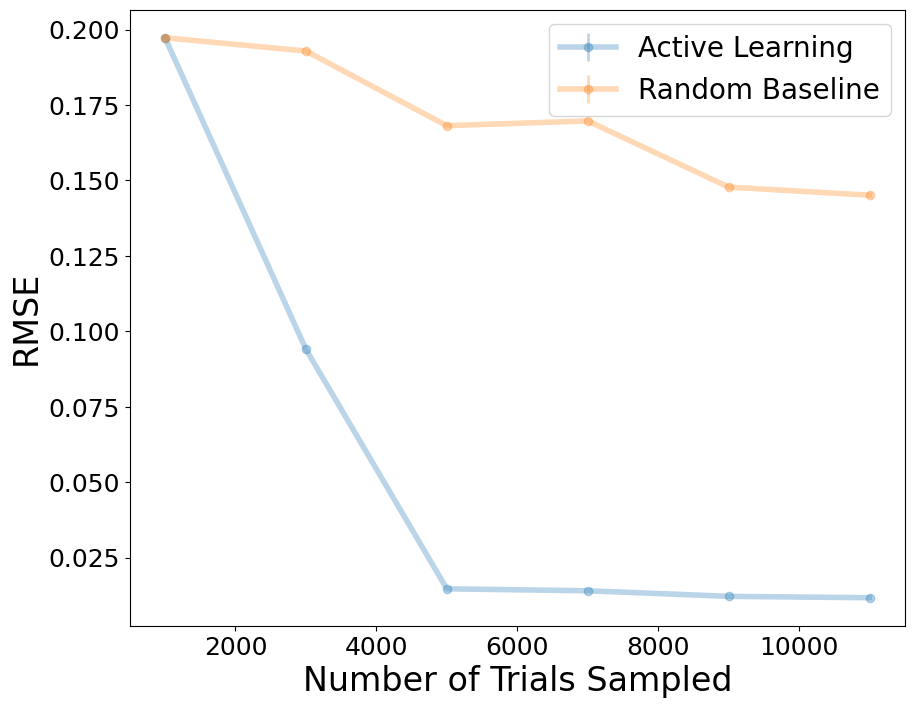

In [13]:
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack), 0), 
             yerr=np.std(np.array(performance_stack), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random), 0), 
             yerr=np.std(np.array(performance_stack_random), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)

# plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

# plt.savefig('performances_5step_p2_n259_adamw.png', dpi=300)

In [ ]:
w_true_t, w_true_nt

In [ ]:
all_combos = fitting.all_combos(np.arange(len(cells)))
ws_full = []
for i in range(len(cells)):
    ws_full.append(np.array(ws[i]))

ws_active = []
ws_active += [np.array(w_final_t)]
ws_active += [np.array(w_final_nt)]

for j in all_combos:
    combo = np.array(j)
    if len(combo) != 0 and len(combo) != len(cells):
        targets = combo
        selectivities_full.append(fitting.selectivity_triplet(ws_full, targets))
        selectivities_active.append(fitting.selectivity_triplet(ws_active, targets))
        datasets.append((dataset, wnoise, estim, p, cells, cells[targets]))

In [ ]:
selectivities_full, selectivities_active

In [ ]:
datasets

In [ ]:
x = np.array(selectivities_full)[:, 1]
y = np.vstack((np.array(selectivities_full)[:, 0], np.array(selectivities_active)[:, 0])).T

lines = []
for i, j in zip(x, y):
    pair = [(i, j[0]), (i, j[1])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors='k')

fig, ax = plt.subplots()
ax.plot(x, [i for (i,j) in y], 's', c='tab:blue', markersize = 10, alpha=0.8, label='Full Dataset')
ax.plot(x, [j for (i,j) in y], 'o', c='tab:red', markersize = 10, alpha=0.8, label='Subsampled Dataset')
ax.add_collection(linecoll)
ax.plot(np.linspace(-0.01, 1.01, 100), np.linspace(-0.01, 1.01, 100), linestyle='--', c='k')
ax.set_xlabel('Single-Electrode Selectivity', fontsize=22)
ax.set_ylabel('Triplet Selectivity', fontsize=22)
ax.tick_params('both', labelsize=18)
ax.legend(fontsize=16)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('fig2_NER.png', dpi=300)

In [ ]:
np.save('selectivities_full.npy', np.array(selectivities_full))
np.save('selectivities_active.npy', np.array(selectivities_active))
np.save('datasets.npy', np.array(datasets, dtype=object))